![](https://straightpathsql.com/wp-content/uploads/2016/09/straight-path-solutions-logo-header.png)

# Workshop: PowerShell Automation for the DBA

#### _A Straight Path Consulting Course from David Seis_

![](https://raw.githubusercontent.com/microsoft/sqlworkshops/master/graphics/textbubble.png)

## Course Notebook: Module 3 - Advanced Automation with DBA Tools

Welcome to this workshop on _PowerShell Automation for the DBA_. In this Notebook, you'll apply the concepts you learned in this Module.

This Notebook contains recipes for some advanced powershell use cases. <span style="color: var(--vscode-foreground);">You'll need a working knowledge of Powershell Basics and Basic Powershell Automation.</span>

Please run the below script to configure your environment for these demos:

In [3]:
<# Environment Variables #>

$sqlinstance = 'Seis-Work'
$outputPath = "C:\temp\Demo"
$CSVpath = "$outputpath\Home-lab_InstanceTracking.csv" 

If(!(test-path -PathType container $outputPath)) 
{ 
    New-Item -ItemType Directory -Path $outputPath 
    Write-Host "$outputPath Directory was created"
}

Write-Host "Environment configured"


    Directory: C:\temp

Mode                 LastWriteTime         Length Name
----                 -------------         ------ ----
d----            3/8/2025 11:33 AM                Demo
C:\temp\Demo Directory was created
Environment configured



## 3.1 Advanced PowerShell Automation: Files

## 

In the context of database administration, PowerShell’s versatility shines through its ability to save outputs in various relevant file formats. Tasks such as exporting data to CSV or generating reports in HTML format, which can be cumbersome when done manually, are made simple and efficient with PowerShell.

In [ ]:
<# Credentials and Targets#>
$SQLInstance =  "Seis-Work,1433", "Seis-Work,1434", "Seis-Work,1435", "Seis-Work,1436", "Seis-Work,1437", "Presenter"
$cred = $host.ui.PromptForCredential("SQL Credential", "Please enter the username and password for the SQL Auth account", "sa", "")

Set-DbatoolsConfig -FullName sql.connection.trustcert -Value $true -register 

$DemoDir = "C:\Temp\Demo"
If(!(test-path -PathType container $DemoDir))   
    { New-Item -ItemType Directory -Path $DemoDir   | Out-Null }



SQL Credential
Please enter the username and password for the SQL Auth account



In [ ]:
<# Code to create the Instance tracking csv #> 


Write-Host "Instance tracking..." -ForegroundColor Green
Foreach ($inst in $SQLInstance) {
$serverdetails = Invoke-dbaquery -SqlInstance $Inst -SqlCredential $cred -Query "
IF OBJECT_ID('tempdb..#ola') IS NOT NULL
DROP TABLE #ola
    CREATE TABLE #ola (
    DbName NVARCHAR(100)
    , Ola_Version nvarchar(10)
    )
        INSERT #ola
        EXEC sp_MSforeachdb '
        USE [?]
        SELECT DISTINCT db_name(), CASE WHEN CHARINDEX(N''--// Version: '', OBJECT_DEFINITION(obj.[object_id])) > 0 
        THEN CAST(LEFT(SUBSTRING(OBJECT_DEFINITION(obj.[object_id]),CHARINDEX(N''--// Version: '',OBJECT_DEFINITION(obj.[object_id])) + LEN(N''--// Version: '') + 1, 19),10) AS NVARCHAR(10)) END 
        FROM sys.objects AS obj
        INNER JOIN sys.schemas AS sch 
        ON obj.[schema_id] = sch.[schema_id]
        WHERE sch.[name] = N''dbo''
        AND obj.[name] IN (N''CommandExecute'')'


IF OBJECT_ID('tempdb..#FR') IS NOT NULL
DROP TABLE #FR
    CREATE TABLE #FR (
    dbName NVARCHAR(100)
    , FRDate nvarchar(10)
    )
        INSERT #FR
        EXEC sp_MSforeachdb '
        USE [?]
        SELECT DISTINCT db_name(), 
        CAST(CAST(create_date as DATE) as NVARCHAR(10))
        FROM sys.objects AS obj
        WHERE obj.[name] LIKE ''SP_Blitz'''

        IF EXISTS (SELECT * FROM sysobjects WHERE type = 'P' AND name = 'sp_Blitz')
        BEGIN
        DECLARE @VersionOutput VARCHAR(30), @VersionDateOutput DATETIME;
        EXEC sp_Blitz 
        @Version = @VersionOutput OUTPUT, 
        @VersionDate = @VersionDateOutput OUTPUT,
        @VersionCheckMode = 1;
        END 

        DECLARE @num_logs int;
        EXEC xp_instance_regread N'HKEY_LOCAL_MACHINE',N'Software\Microsoft\MSSQLServer\MSSQLServer',N'NumErrorLogs',@num_logs OUTPUT;


SELECT  
    getdate() as Run_Date
    ,   SERVERPROPERTY('MachineName') AS Machine_Name
    ,   SERVERPROPERTY('ServerName') AS Instance_Name
    ,   CASE 
            WHEN Convert(nvarchar(20),SERVERPROPERTY('ProductVersion')) LIKE '16.%' THEN 2022
            WHEN Convert(nvarchar(20),SERVERPROPERTY('ProductVersion')) LIKE '15.%' THEN 2019
            WHEN Convert(nvarchar(20),SERVERPROPERTY('ProductVersion')) LIKE '14.%' THEN 2017
            WHEN Convert(nvarchar(20),SERVERPROPERTY('ProductVersion')) LIKE '13.%' THEN 2016
            WHEN Convert(nvarchar(20),SERVERPROPERTY('ProductVersion')) LIKE '12.%' THEN 2014
            WHEN Convert(nvarchar(20),SERVERPROPERTY('ProductVersion')) LIKE '11.%' THEN 2012
            WHEN Convert(nvarchar(20),SERVERPROPERTY('ProductVersion')) LIKE '10.%' THEN 2008
            ELSE NULL 
        END AS [SQL_Version]
    ,   SERVERPROPERTY('Edition') AS SQL_Edition
    ,   SERVERPROPERTY('ProductLevel') AS Product_Level
    ,   SERVERPROPERTY('ProductUpdateLevel') AS Update_Level
    ,   SERVERPROPERTY('ProductVersion') AS SQL_Build
    ,   (SELECT Ola_Version FROM #ola WHERE DbName in ('DB_Administration','Maintenance','DBA')) AS Ola_Version
    ,   (SELECT CAST(@VersionOutput as NVARCHAR(5)) FROM #FR WHERE dbName in ('master')) AS First_Responder_Version
    ,   (SELECT service_account FROM sys.dm_server_services WHERE servicename like 'SQL Server (%') as SQL_Account
    ,   (SELECT service_account FROM sys.dm_server_services WHERE servicename like 'SQL Server Agent%') as SQL_Agent_Account
    ,   (SELECT datediff(day, sqlserver_start_time, getdate()) FROM sys.dm_os_sys_info) as Uptime_Days
    ,   (SELECT is_disabled FROM sys.server_principals WHERE sid = 0x01 ) as is_sa_disabled
    ,   CONNECTIONPROPERTY('local_net_address') AS local_net_address
    ,   CONNECTIONPROPERTY('local_tcp_port') AS local_tcp_port
    ,   @num_logs as num_error_logs
    ,   GETDATE() AS Collection_Date

" 

    If(!(test-path $CSVpath)){
        $ServerDetails | Export-Csv -Path $CSVpath -Delimiter "," -NoTypeInformation
    } ELSE {
        $ServerDetails | Export-Csv -Path $CSVpath -Delimiter "," -NoTypeInformation -Append
    }
    }


Instance tracking...


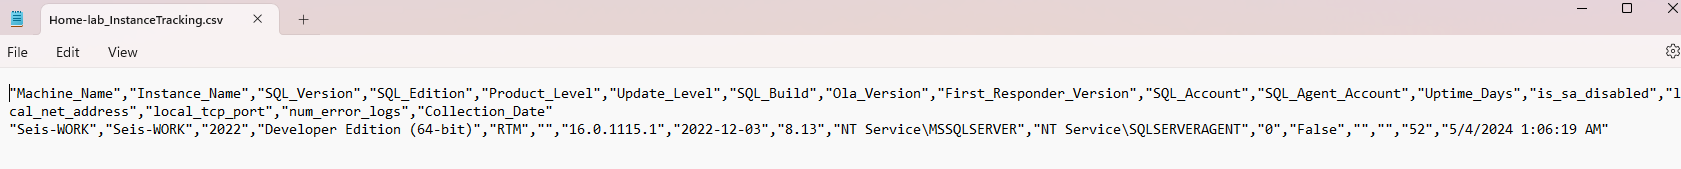

## 3.2 Advanced PowerShell Automation: Loading and Processing Data

PowerShell can replace values, modify data, and load data into a sql server instance, as well as calling follow-up stored procedures to process the data once loaded.

In [34]:
New-DbaDatabase -SqlInstance "Presenter" -name "Admin" -SqlCredential $cred

Import-DbaCsv -Path "C:\Temp\Demo\Home-lab_InstanceTracking.csv"  -SqlInstance "Presenter" -SqlCredential $cred -Database "Admin" -AutoCreateTable



ComputerName  : Presenter
InstanceName  : MSSQLSERVER
SqlInstance   : Presenter
Database      : Admin
Table         : Home-lab_InstanceTracking
Schema        : dbo
RowsCopied    : 6
Elapsed       : 173.02 ms
RowsPerSecond : 34.9
Path          : C:\Temp\Demo\Home-lab_InstanceTracking.csv



Error: Database Admin already exists on Presenter

In [35]:
<# Code to show that the tabel is present - Using Invoke-DBAquery from Dbatools #> 

invoke-dbaquery -sqlinstance "Presenter" -SQLcredential $cred -query  "

	SELECT [Machine_Name]
      ,[Instance_Name]
      ,[SQL_Version]
      ,[SQL_Edition]
      ,[Product_Level]
      ,[Update_Level]
      ,[SQL_Build]
      ,[Ola_Version]
      ,[First_Responder_Version]
      ,[SQL_Account]
      ,[SQL_Agent_Account]
      ,[Uptime_Days]
      ,[is_sa_disabled]
      ,[local_net_address]
      ,[local_tcp_port]
      ,[num_error_logs]
      ,[Collection_Date]
  FROM [Admin].[dbo].[Home-lab_InstanceTracking]

        
" | Format-Table


Machine_Name Instance_Name SQL_Version SQL_Edition                Product_Level Update_Level SQL_Bu
                                                                                             ild
------------ ------------- ----------- -----------                ------------- ------------ ------
b34273dee487 SQL1          2022        Developer Edition (64-bit) RTM           CU17         16.0.…
ab8d15360540 SQL2          2022        Developer Edition (64-bit) RTM           CU17         16.0.…
b80f4016592c SQL3          2022        Developer Edition (64-bit) RTM           CU17         16.0.…
d67d27d52bf5 SQL4          2019        Developer Edition (64-bit) RTM           CU32         15.0.…
44147f246138 SQL5          2017        Developer Edition (64-bit) RTM           CU31         14.0.…
Presenter    Presenter     2022        Developer Edition (64-bit) RTM                        16.0.…



In [36]:
<# query to get action items from the data #>

Invoke-DbaQuery -SqlInstance "Presenter" -SqlCredential $cred -Query "
USE Admin
SELECT 
machine_name
,	Instance_name
,   'Sa is enabled for login - please correct immediately'
FROM [ADMIN].[dbo].[Home-lab_InstanceTracking]
Where is_sa_disabled = 'False'
" 


machine_name Instance_name Column1
------------ ------------- -------
b34273dee487 SQL1          Sa is enabled for login - please correct immediately
ab8d15360540 SQL2          Sa is enabled for login - please correct immediately
b80f4016592c SQL3          Sa is enabled for login - please correct immediately
d67d27d52bf5 SQL4          Sa is enabled for login - please correct immediately
44147f246138 SQL5          Sa is enabled for login - please correct immediately
Presenter    Presenter     Sa is enabled for login - please correct immediately



In [ ]:
<# Environment Cleanup #>
Remove-Item -Path $CSVpath 

If((test-path -PathType container $outputPath)) 
{ 
    remove-Item -Path $outputPath
    Write-Host "$outputPath Directory was removed"
}

Invoke-DbaQuery -SqlInstance "Presenter" -SqlCredential $cred -Query "
    DROP DATABASE ADMIN
" 

Write-Host "Environment cleaned"

C:\temp\Demo Directory was removed
Environment cleaned


In [ ]:
<# Create a report and task inside of task scheduler to check recent job runs #>


    ## DEPENDENCIES
    # 1. Dbatools
    # 2. Service account acctess to all monitored servers

    <# Necessary Variables #>
    $reportname = "Job Run Report"

    $ClientName = 'Test-Lab' 
    $jobserver = 'Seis-Work'
    $monitoringTarget = $sqlinstance

    $ServiceAccount = $host.ui.PromptForCredential("Task Scheduler account", "Please enter the domainname\username and password for the service account that will run the tasks (password expiry = never is ideal). ", "DOMAIN\Account", "")

    $EmailRecipients = 'David.seis@straightpathsql.com;' #separate with semicolons

    Write-Host "Creating Powershell File..." -ForegroundColor Green
    New-Item -Path "\\$jobserver\C`$\StraightPath\Reports" -Name "$reportname`Script.ps1" -ItemType 'file' -value "
        
    <# Create C:\StraightPath\Reports for all the reports to go into#>
        `$dir = `"\\$jobserver\C$\StraightPath\Reports`"
        If(!(test-path -PathType container `$dir))
        {
            New-Item -ItemType Directory -Path `$path
        }
        `$path=`"\\$jobserver\C$\StraightPath\Reports\$clientname`_$reportname`$(get-date -f MM-dd-yyyy).htm`"

        `$SQLInstance= `"$monitoringTarget`"

    <#Define an Empty Array to Hold all of the HTML Fragments #>
        `$fragments = @()

    #Define the HTML style
        `$head = `"
            <style>
            body { background-color:#FAFAFA; font-family:Arial; font-size:12pt; }
            td, th { border:1px solid black; border-collapse:collapse; }
            th { color:white; background-color:black; }
            table, tr, td, th { padding: 2px; margin: 0px }
            tr:nth-child(odd) {background-color: lightgray}
            table { margin-left:50px; }
            </style>

            <H2>Daily Job Run report</H2>
            <H3>Automated powershell script from Straight Path IT Solutions, LLC.</H3>
            `"


        `$results = Invoke-DbaQuery -SQLInstance `$SQLInstance -Query `"
        WITH jobhistory as (   
            SELECT    job_id,
                        Max(instance_id) instance_id
            FROM      msdb.dbo.sysjobhistory
            WHERE     step_id = 0
                        AND run_status is not null
                        
            GROUP BY job_id
            --   order by run_status asc
            )
            SELECT  --  j.job_id,
                    j.name,
                    CASE sjh.run_status
                WHEN 0 THEN 'Failed'
                WHEN 1 THEN 'Succeeded'
                WHEN 2 THEN 'Retry'
                WHEN 3 THEN 'Canceled'
                WHEN 4 THEN 'In Progress'
                else 'boogy man'
            END RunStatus,
            --  jh.run_status,
            last_run_time =  (msdb.dbo.agent_datetime(run_date, run_time)),
                        last_end_time = (dateadd(ss,run_duration % 100 + ROUND((run_duration % 10000) / 100, 0, 0) * 60 + ROUND((run_duration % 1000000) / 10000, 0, 0) * 3600 ,msdb.dbo.agent_datetime(run_date, run_time)))
            --  ,j.enabled 
            
            ,
            CASE SJ.next_run_date
                        WHEN 0 THEN cast('n/a' as char(10))
                        ELSE convert(char(10), convert(datetime, convert(char(8),SJ.next_run_date)),120)  + ' ' + left(stuff((stuff((replicate('0', 6 - len(next_run_time)))+ convert(varchar(6),next_run_time),3,0,':')),6,0,':'),8)
                    END AS NextRunTime
            --           jh.duration
            FROM      msdb.dbo.sysjobs j
                    LEFT OUTER JOIN jobhistory jh
                    ON j.job_id = jh.job_id
                    join msdb..sysjobhistory sjh
                    on jh.instance_id = sjh.instance_id
                    left join msdb.dbo.sysjobschedules SJ on J.job_id = SJ.job_id  
            left join msdb.dbo.sysschedules SS on SS.schedule_id = SJ.schedule_id
            
            where sjh.run_status is not null
                and j.enabled = 1
            ORDER BY Runstatus,last_end_time desc 
        
        `" | Select-object * -ExcludeProperty RowError, RowState, Table, ItemArray, HasErrors | ConvertTo-Html | Out-String

        `$fragments += `"<br>$reportname</i>`"
        `$fragments += `$results 

        ConvertTo-HTML -Head `$head -Body `$fragments -PostContent `"<br><br><i>report generated: `$(Get-Date)</i> from $jobserver.`" | Out-File -FilePath `$path -Encoding ascii

        `$output = ConvertTo-HTML -Head `$head -Body `$fragments -PostContent `"<br><br><i>Report generated on `$(Get-Date)</i> via powershell on $jobserver.`" | Out-File -FilePath `$path -Encoding ascii

        #Define mail variables
        `$subject = `"$Reportname : `$(Get-Date -f MM-dd-yyyy)`" 

        Write-Host `"Sending email...`" -ForegroundColor Green
        [Net.ServicePointManager]::SecurityProtocol = [Net.SecurityProtocolType]::Tls12
        `$Parameters = @{
            FromAddress     = `"alertinbox@straightpathsql.com`"
            ToAddress       = `"$EmailRecipients`"
            CCAddress       = `"alertinbox@straightpathsql.com`"
            Subject         = `"$reportname for $Client_Name attached!`"
            Body            = `"Please find the $reportname for $Client_Name, attached!`"
            Token           =  Unprotect-CmsMessage -Path C:\temp\Demo\Sendgrid.txt
            FromName        = `"StraightPathSendGrid`"
            ToName          = `"David`"
        }
        Send-PSSendGridMail @Parameters
        "


    Write-Host "Creating XML File..." -ForegroundColor Green
    New-Item -Path "\\$jobserver\C$\Straightpath\Reports" -Name "$reportname`_Task.xml" -ItemType 'file' -value "<?xml version=`"1.0`" encoding=`"UTF-16`"?>
    <Task version=`"1.2`" xmlns=`"http://schemas.microsoft.com/windows/2004/02/mit/task`">
        <RegistrationInfo>
        <Date>2022-02-23T12:59:09.8081565</Date>
        <Author>David Seis, Straight Path IT Solutions, LLC.</Author>
        <URI>\$reportname</URI>
    </RegistrationInfo>
    <Triggers>
    <CalendarTrigger>
        <StartBoundary>2023-05-31T08:00:00</StartBoundary>
        <Enabled>true</Enabled>
        <ScheduleByDay>
        <DaysInterval>1</DaysInterval>
        </ScheduleByDay>
    </CalendarTrigger>
    <CalendarTrigger>
        <StartBoundary>2023-05-31T07:00:00</StartBoundary>
        <Enabled>true</Enabled>
        <ScheduleByDay>
        <DaysInterval>1</DaysInterval>
        </ScheduleByDay>
    </CalendarTrigger>
    <CalendarTrigger>
        <StartBoundary>2023-05-31T09:00:00</StartBoundary>
        <Enabled>true</Enabled>
        <ScheduleByDay>
        <DaysInterval>1</DaysInterval>
        </ScheduleByDay>
    </CalendarTrigger>
    </Triggers>
    <Principals>
        <Principal id=`"Author`">
        <UserId>$($ServiceAccount.GetNetworkCredential().username)</UserId>
        <LogonType>Password</LogonType>
        <RunLevel>HighestAvailable</RunLevel>
        </Principal>
    </Principals>
    <Settings>
        <MultipleInstancesPolicy>IgnoreNew</MultipleInstancesPolicy>
        <DisallowStartIfOnBatteries>true</DisallowStartIfOnBatteries>
        <StopIfGoingOnBatteries>true</StopIfGoingOnBatteries>
        <AllowHardTerminate>true</AllowHardTerminate>
        <StartWhenAvailable>false</StartWhenAvailable>
        <RunOnlyIfNetworkAvailable>false</RunOnlyIfNetworkAvailable>
        <IdleSettings>
        <StopOnIdleEnd>true</StopOnIdleEnd>
        <RestartOnIdle>false</RestartOnIdle>
        </IdleSettings>
        <AllowStartOnDemand>true</AllowStartOnDemand>
        <Enabled>true</Enabled>
        <Hidden>false</Hidden>
        <RunOnlyIfIdle>false</RunOnlyIfIdle>
        <WakeToRun>false</WakeToRun>
        <ExecutionTimeLimit>P3D</ExecutionTimeLimit>
        <Priority>7</Priority>
    </Settings>
    <Actions Context=`"Author`">
    <Exec>
        <Command>Powershell.exe</Command>
        <Arguments>-ExecutionPolicy Unrestricted -File `"C:\StraightPath\Reports\$reportname`_Script.ps1`"</Arguments>
    </Exec>
    </Actions>
    </Task>"

    Register-ScheduledTask -Xml (get-content "\\$jobserver\C$\StraightPath\Reports\$reportname`_Task.xml" | out-string) -Taskname "_REPORT_$reportname" -User ($ServiceAccount.GetNetworkCredential().username) -Password $($ServiceAccount.GetNetworkCredential().Password) 


## 3.4 Advanced PowerShell Automation: Tooling

Using powershell to simplify repetitive but important tasks such as patching, keeping tools up to date and making sure systems are meeting internal compliance standards is a time saving effort. There is some time to building and testing these scripts, but the time dividends are remarkable.

In [ ]:
<# SSMS update script #>
    
    $uninstallold = 0

    <# Current install audit #>    
    Get-WmiObject Win32_product | Where-Object {$_.name -eq "SQL Server Management Studio"} | ForEach-object {
        Write-Host "SSMS: Currently Installed Versions of SSMS [Version: $($_.Version)]`..." -ForegroundColor Green
    }


    <# New Installer download #>
    $ssmsUrl = "https://aka.ms/ssmsfullsetup"
    $destination = "C:\Temp\ssms_installer.exe"

    try {
        Write-Host "SSMS: Downloading newest SSMS Installer..." -ForegroundColor Green
        $WebClient = New-Object System.Net.WebClient
        $webclient.DownloadFile($ssmsUrl, $destination)
    }
    catch {
        Write-Host "Unable to download the latest SSMS installer, please download and install manually." -ForegroundColor Red -BackgroundColor White
        return
    }

    IF($uninstallold -eq 1) {
    <# Installer was successfully downloaded, uninstall old ssms versions #>
    Write-Host "SSMS: SSMS Update flag was on, enumerating SSMS installs..." -ForegroundColor Green
        Invoke-Command -ScriptBlock {
            Get-WmiObject Win32_product | Where-Object {$_.name -eq "SQL Server Management Studio"} | ForEach-object {
                Write-Host "SSMS: Uninstalling SSMS [Version: $($_.Version)]`..." -ForegroundColor Green
                $_.Uninstall() | Out-null
            }
        }
    }

    # Install SSMS silently
    $install_path = "`"C:\Program Files (x86)\Microsoft SQL Server Management Studio 20`""
    $params = " /Install /Passive SSMSInstallRoot=$install_path /quiet"
            
    Write-Host "SSMS: Installing SSMS..." -ForegroundColor Green
    Start-Process -FilePath $destination -ArgumentList $params -Wait
    Remove-Item $destination
    #Write-Host "SSMS: Server restart is required to implement changes fully" -ForegroundColor DarkRed
    Invoke-Command -ScriptBlock {
        Get-WmiObject Win32_product | Where-Object {$_.name -eq "SQL Server Management Studio"} | ForEach-object {
            Write-Host "SSMS: Currently Installed Versions of SSMS [Version: $($_.Version)]`..." -ForegroundColor Green
        }
    }

## 3.3 Advanced PowerShell Automation: Task Scheduling

The ability to create a script and then call them via tasks cheduler jobs is extermely useful, especially when you consider the versatility and range of Powershell, and th ebreadth of data you can access for these reports.

This script works but requires an environment where you have access to a service account that has log on as batch service as well as access to the targeted servers.